In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pygsp as pygsp
from pygsp import graphs, filters, reduction

from tqdm import tqdm
import numpy as np
import random


In [5]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    df = pd.read_csv(file)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls
def plot_graphnx(G, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):
    """
    Plot a single graph G using networkx.
    pos : dict, optional
        A dictionary with nodes as keys and positions as values.
        If not provided, will use spring layout.

    """
    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)

    # Draw edges and nodes
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=alpha)

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig


In [12]:
def get_dg_initial_node(G):
    initial_nodes = []
    for node, in_deg in G.in_degree():
        if in_deg == 0:
            initial_nodes.append(node)
    print("Initial nodes: ", initial_nodes)
    return initial_nodes

def get_dg_unique_nodes(G):
    res = set(G.nodes)
    print("Num of nodes: ", len(res))
    return res

In [6]:
    # Extract to dataframe
df = csv_to_df("./MSCallGraph_0.csv")

# Extract all tids
tids_list = df['traceid'].unique()
print("Num of tids: ", len(tids_list))

Num of tids:  130512


  0%|          | 3/130512 [00:00<4:56:04,  7.35it/s]

len tid: 16


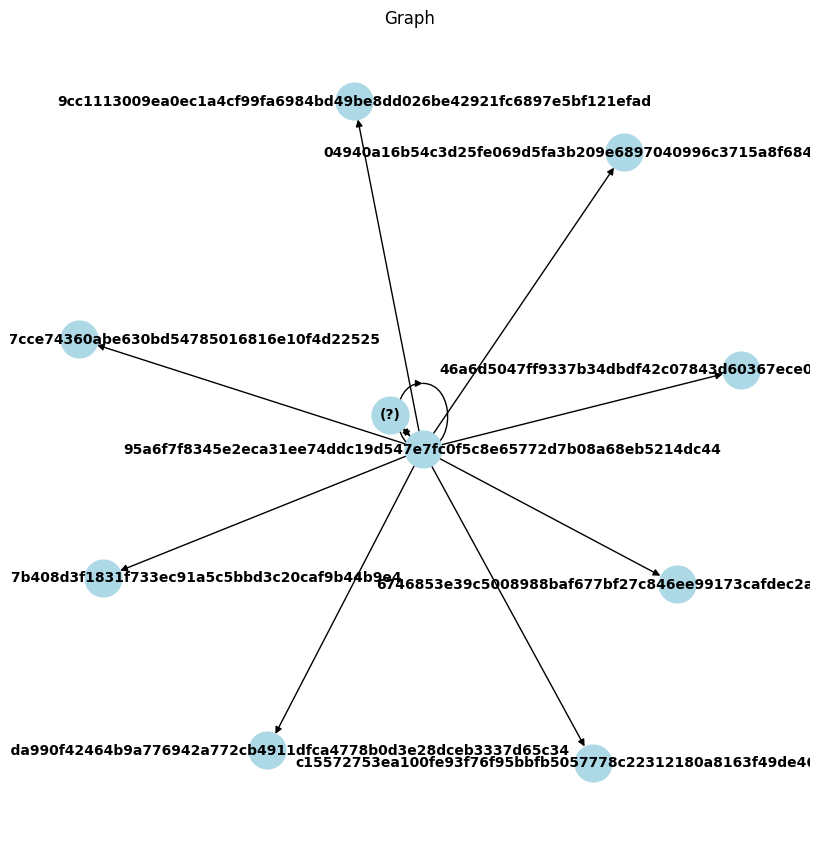

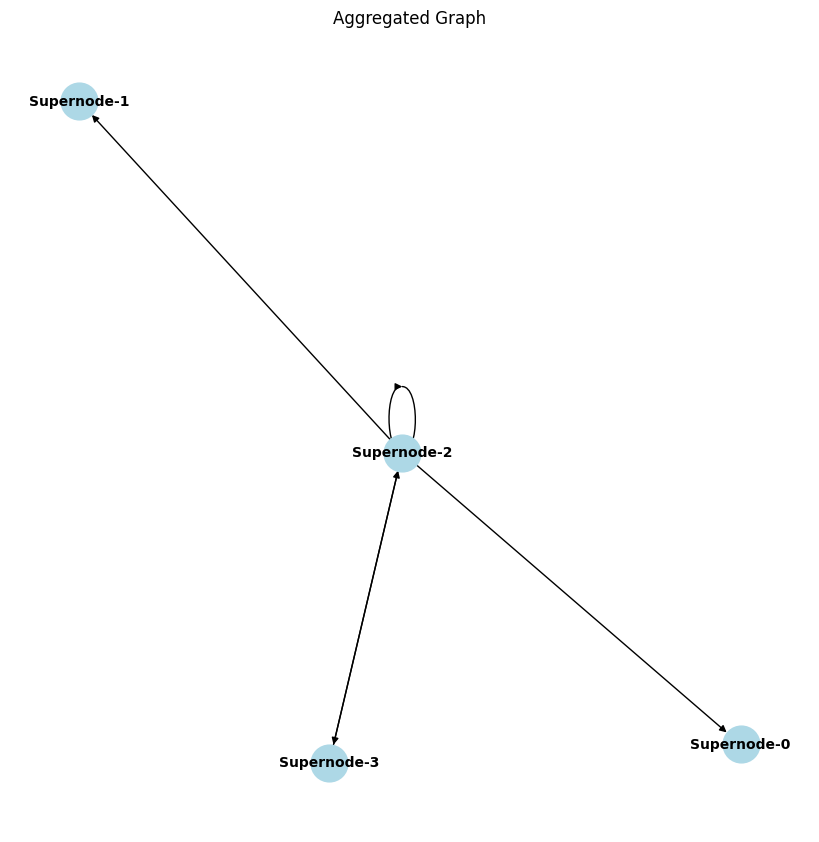

In [31]:
ctr = 0
all_edges = []
all_nodes = []
for i in tqdm(range(len(tids_list))):
    if i in [0,1,2]:
        continue
    ctr += 1
    tid_calls = extract_traceid_rows(df, tids_list[i])
    for call in tid_calls:
        all_edges.append([call.um, call.dm])
        all_nodes.append(call.um)
        all_nodes.append(call.dm)
    print("len tid:", len(tid_calls))
    if ctr == 1:
        break
all_nodes = set(all_nodes)

G = nx.DiGraph()
G.add_edges_from(all_edges)
plot_graphnx(G)

node_types = {node: random.choice(['type1', 'type2']) for node in all_nodes}
nx.set_node_attributes(G, node_types, 'type')

# Define the node attributes to aggregate on
node_attributes = ("type",)

# Perform the snap aggregation
Gs = nx.snap_aggregation(G, node_attributes=node_attributes)

# Plot the aggregated graph
plot_graphnx(Gs, title="Aggregated Graph")


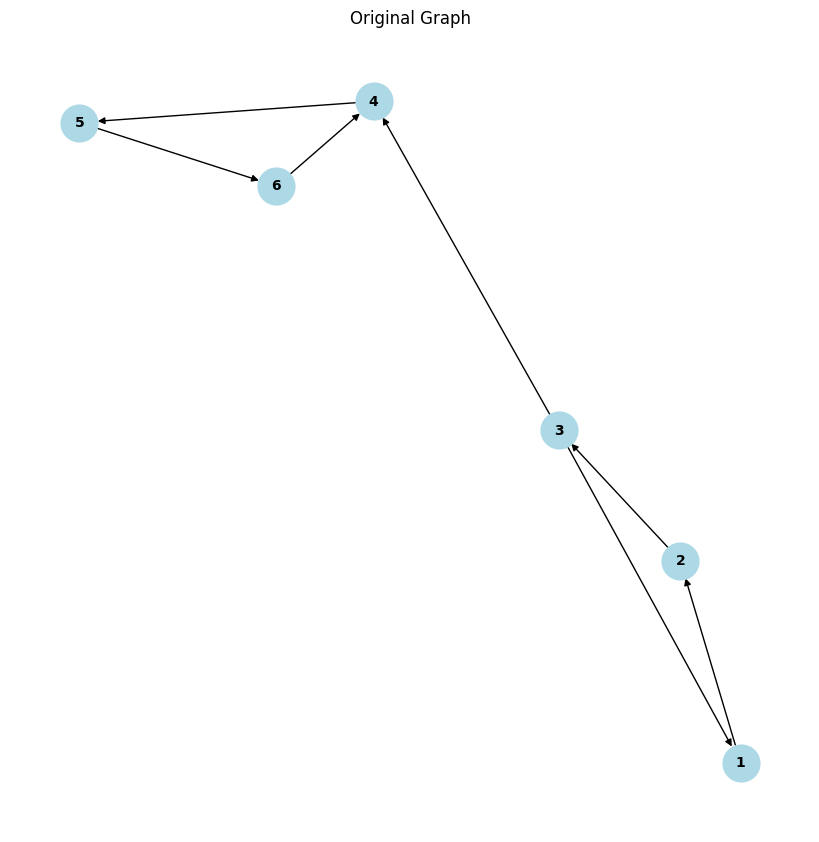

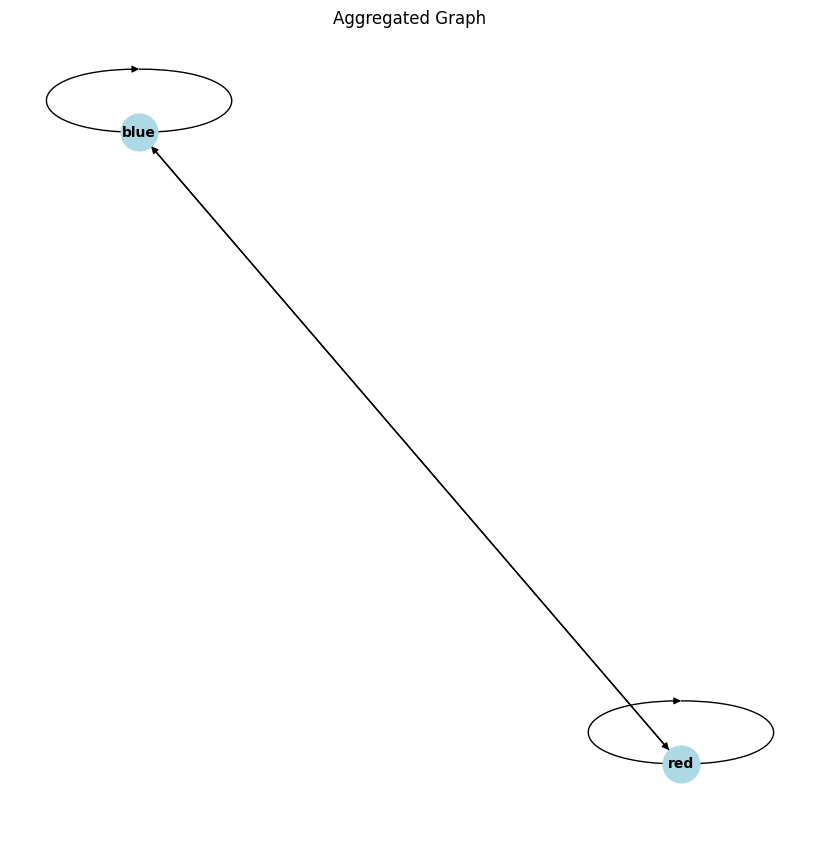

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_graphnx(G, title="Graph"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title(title)
    plt.show()

# Create a directed graph and add edges
all_edges = [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 6), (6, 4)]
G = nx.DiGraph()
G.add_edges_from(all_edges)

# Define node attributes
node_colors = {1: 'red', 2: 'blue', 3: 'red', 4: 'blue', 5: 'red', 6: 'blue'}
nx.set_node_attributes(G, node_colors, 'color')

# Plot the original graph
plot_graphnx(G, title="Original Graph")

# Manual Aggregation
grouped_nodes = defaultdict(list)
for node, data in G.nodes(data=True):
    color = data['color']
    grouped_nodes[color].append(node)

# Create the aggregated graph
Gs = nx.DiGraph()

# Add the supernodes
for color, nodes in grouped_nodes.items():
    Gs.add_node(color)

# Add the edges between supernodes
for u, v in G.edges():
    color_u = G.nodes[u]['color']
    color_v = G.nodes[v]['color']
    if Gs.has_edge(color_u, color_v):
        Gs[color_u][color_v]['weight'] += 1
    else:
        Gs.add_edge(color_u, color_v, weight=1)

# Plot the aggregated graph
plot_graphnx(Gs, title="Aggregated Graph")
